# Latent Semantic Analysis (LSA)

En esta notebook vamos a reducir la dimensionalidad de un conjunto de textos mediante LSA, que consiste en encontrar las componentes singulares de la matriz de documentos por términos.
La decomposición en valores singulares se conoce como SVD (*Singular Value Decomposition*) y es prácticamente igual al análisis de componentes principales (PCA), salvo en algunos detalles sobre el escaleo o no de las variables, y en la matriz sobre la cual se aplica cada método (en SVD se trabaja sobre la matriz de instancias en el espacio de features mientras que PCA trabaja sobre la matriz de covarianza de los features).
Muchos conceptos vistos en PCA se aplican acá también:

- los valores singulares nos dicen cuánta información está contenida en cada componente.
- las componentes vienen ordenadas de la más informativa a la menos.

Reducir la dimensión suele ser una buena práctica a la hora de medir distancias (comparar) entre datos: en vez de hacerlo en el espacio original es mejor operar en el espacio reducido.



In [ ]:
# Importamos las librerías habituales
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pylab as plt
import numpy as np

Mounted at /content/drive


In [ ]:
# Importamos nltk para extraer stopwords
import nltk
nltk.download('stopwords')

# Librería para hacer wordclouds
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Objetos de sklearn para hacer LSA
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition

Cargamos el dataset con el que vamos a trabajar desde la carpeta de la materia. Vamos a utilizar el dataset de la clase de *sentiment* sobre letras de distintos ritmos musicales:

In [ ]:
# Path de nuestro dataset
filename = '/content/drive/My Drive/LaboDatos2022/todo_tangos.csv'

# Carga del dataset
df = pd.read_csv(filename)

# Vemos las primeras filas
df.head()

,url,titulo,ritmo,autor_letra,autor_musica,letra,ano
0,https://www.todotango.com/musica/tema/130/A-ba...,A bailar,Tango,Homero Expósito,Domingo Federico,¡A bailar a bailar que la orquesta se va! Sobr...,1943.0
1,https://www.todotango.com/musica/tema/7866/A-b...,A bailar el tango,Tango,Leopoldo Díaz Vélez,Leopoldo Díaz Vélez,Este tango nació para bailarse y así hamacarse...,1962.0
2,https://www.todotango.com/musica/tema/3647/A-B...,A Beba Bidart,Poemalunfardo,Alberto Uemura,NaN,Nació en la calle Quito entre Boedo y Colombre...,NaN
3,https://www.todotango.com/musica/tema/2864/A-b...,A bordo de mis zapatos,Milonga,Eugenio Majul,César Isella,Caminé todas las calles de Buenos Aires y es c...,NaN
4,https://www.todotango.com/musica/tema/3843/A-B...,A Buenos Aires,Milonga,Edmundo Rivero,Edmundo Rivero,En tu baraje gringo ciudad mía vas perdiendo t...,NaN


Vamos a quedarnos con canciones pertenecientes al tango y con datos donde haya información de la letra:

In [ ]:
# Nos quedamos solo con los datos pertenecientes al tango
df = df[df['ritmo'] == 'Tango'].copy()

# Nos quedamos con solo las datos donde esté especificada la letra
df.dropna(subset = ['letra'], inplace = True)

# Reseteamos el índice
df.reset_index(drop = True, inplace = True)

# Vemos las primeras filas
df.head()

,url,titulo,ritmo,autor_letra,autor_musica,letra,ano
0,https://www.todotango.com/musica/tema/130/A-ba...,A bailar,Tango,Homero Expósito,Domingo Federico,¡A bailar a bailar que la orquesta se va! Sobr...,1943.0
1,https://www.todotango.com/musica/tema/7866/A-b...,A bailar el tango,Tango,Leopoldo Díaz Vélez,Leopoldo Díaz Vélez,Este tango nació para bailarse y así hamacarse...,1962.0
2,https://www.todotango.com/musica/tema/6354/A-c...,A cara limpia,Tango,Nolo López,Anselmo Aieta,No te demores que se hace tarde ponete pronto ...,NaN
3,https://www.todotango.com/musica/tema/6455/A-c...,A cara o cruz,Tango,Agustín Irusta,Agustín Irusta,A cara o cruz le dije un día y a cara cruz jug...,NaN
4,https://www.todotango.com/musica/tema/33/A-Cat...,A Cátulo Castillo,Tango,Eladia Blázquez,Eladia Blázquez,Tu muerte fue una tarde muy cálida de Octubre ...,NaN


### Construcción de la matriz documentos-términos

Vamos a construir esta matriz con valorización tf-idf, es decir, además de la frecuencia del término vamos a ponderar la especificidad.
Esto lo hacemos en dos pasos: primero, describimos nuestros datos mediante frecuencia de términos; luego, le agregamos la valorización de la especificidad.
Vamos además a remover las *stopwords* obtenidas de *nltk*.

In [ ]:
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')

# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['letra'])

# Dimensions de la matriz doc-tér
print(x_count.shape)

(3981, 16661)


Podemos tranquilamente trabajar sobre la matriz de documentos descritos a través de la frecuencia de las palabras o bien, como es habitual, ponderar la especificidad de los términos mediante tf-idf. Esto lo hacemos de la siguiente manera:

In [ ]:
# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

### Aplicación de LSA sobre el corpus

Reduzcamos la dimensionalidad de nuestro corpus de textos a través de hallar los valores singulares. Elijamos por ejemplo 300 dimensiones:

In [ ]:
# Dimensión del espacio reducido
n_components = 300

# Creación del objeto SVD
svd = TruncatedSVD(n_components = n_components)

Sigamos el mismo procedimiento del [paper original de LSA](https://mainline.brynmawr.edu/Courses/cs380/fall2006/intro_to_LSA.pdf) (o al menos uno de los mas citados), en el cual en vez de disponer la matriz de los datos como documentos en las filas y términos en las columnas, la disponen traspuesta (cada término es una fila y cada documento es una columna). Ver al final un pequeño comentario sobre esto.

Para hacer esto, simplemente trasponemos la matriz antes de buscar valores singulares:

In [ ]:
# Ajuste con los datos y descripción en el espacio reducido
# Trabajamos con la matriz traspuesta
x_svd = svd.fit_transform(x_tfidf.T)

# Dimensión de la matriz de datos en el espacio reducido
print(x_svd.shape)

(16661, 300)


Notemos que la matriz transformada tiene tantos términos por la cantidad de componentes singulares.

Al igual que con PCA podemos ver la cantidad de información que retuvimos al hacer la reducción dimensional:

Text(0.5, 0, 'Cantidad de valores singulares')

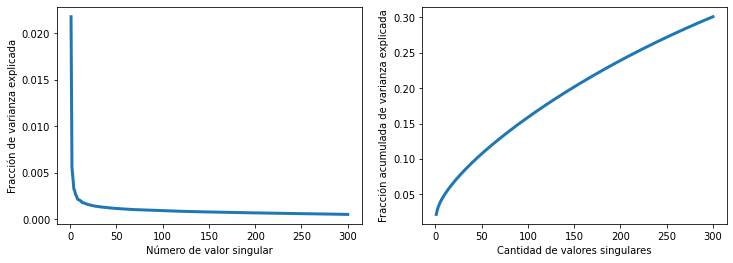

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = svd.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 3)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de valor singular')

# Calculamos el acumulado con la función cumsum de numpy
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 3)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de valores singulares')

Así vemos que con 300 dimensiones captamos alrededor del 30% de la información.

### Operaciones en el espacio reducido. Términos similares.

Descrito los términos en el espacio reducido podemos ver la similitud entre ellos. Lo que hicimos al reducir la dimensión fue identificar términos que aparecen en contextos similares, lo cual resalta cuándo dos términos estan relacionados. Veamos un ejemplo:

In [ ]:
# Identifiquemos el índice de alguna palabra de referencia
index_word = count.vocabulary_['parís']

En *count.vocabulary_* nos encontramos un diccionario que linkea un dado término con el índice correspondiente. Algo que nos va a ser útil es hacer el proceso inverso: a partir de un índice, obtener el término correspondiente. Esto lo hacemos con el siguiente objeto:

In [ ]:
# Diccionario índice: término
vocabulary = {item: key for key, item in count.vocabulary_.items()}

Por otro lado, vamos a tomar como medida de similaridad a la distancia coseno, definida como:

$$ d(\bar u,\bar v) = 1 - \frac{\bar u \cdot \bar v}{|u|_2|v|_2}$$

que vale 0 si los vectores son apuntan en la misma dirección y 1 si son ortogonales. Definamos la similaridad como 1 menos la distancia coseno:

In [ ]:
from scipy.spatial.distance import cosine as cosine_distance

# Calculo las distancia coseno del término de referencia respecto de los otros
similarities = [1.00 - cosine_distance(x_svd[index_word], x_svd[i]) for i in range(x_svd.shape[0])]

Ahora nos interesa encontrar los terminos más similares. Esto lo hacemos con la librería *heapq* que nos permite encontrarlas rápidamente:

In [ ]:
import heapq

# Encuentra las 10 similaridades más grande
max_matching = heapq.nlargest(10, similarities)

# Encuentra los índices correspondiente a las similaridades más altas
max_matching_index = [np.where(similarities == m)[0][0] for m in max_matching]

# Devuelve los términos correspondientes a cada índice
for i in max_matching_index:
  print(vocabulary[i])

parís
boulevard
barbudos
navaja
bulevar
aime
montmartre
piantate
comisaría
bois


#### Relaciones entre documentos

Una vez que estamos en un espacio de dimensión reducida podemos tratar de buscar similitud entre documentos. Por ejemplo, podemos ver cuales son las letras más similares a "Volver", de Gardel y Lepera (que dúo, no?).

In [ ]:
# Buscamos el índice de la canción Volver
track_index = df[df['titulo'] == 'Volver'].index[0]

¿Dónde encontramos información de los documentos? Recordemos de PCA que podíamos obtener las componentes principales, aquí lo mismo. Vemos las dimensiones:

In [ ]:
# Dimensiones de las componentes singulares
print(svd.components_.shape)

(300, 3981)


Al ver las dimensiones nos damos cuenta que trasponer esta matriz obtenemos los documentos en el espacio de dimensión reducida. Podemos calcular la similitud entre ellos o respecto de un tema de referencia:

In [ ]:
# Calculo las distancia coseno de la canción respecto de todas las demás canciones
similarities = [1.00 - cosine_distance(svd.components_.T[track_index], svd.components_.T[i]) for i in range(svd.components_.shape[1])]

In [ ]:
# Buscamos las 5 similaridades más grandes
max_matching = heapq.nlargest(5, similarities)

# Printemos las similaridades
print(max_matching)

# Encuentra los índices correspondiente a las similaridades más altas
max_matching_index = [np.where(similarities == m)[0][0] for m in max_matching]

# Imprimimos los datos de las canciones más similares
df.iloc[max_matching_index]

[1.0, 0.29106960468300436, 0.27115818968583616, 0.26208965395800377, 0.25120909841162387]


,url,titulo,ritmo,autor_letra,autor_musica,letra,ano
3811,https://www.todotango.com/musica/tema/31/Volver/,Volver,Tango,Alfredo Le Pera,Carlos Gardel,Yo adivino el parpadeo de las luces que a lo l...,1935.0
3459,https://www.todotango.com/musica/tema/101/Teng...,Tengo miedo,Tango,Celedonio Flores,José María Aguilar,En la timba de la vida me planté con siete y m...,1928.0
1226,https://www.todotango.com/musica/tema/4002/El-...,El miedo de vivir,Tango,Eladia Blázquez,Eladia Blázquez,El miedo de vivir es el señor y dueño de mucho...,1973.0
953,https://www.todotango.com/musica/tema/690/De-i...,De igual a igual,Tango,Rodolfo Sciammarella,Rodolfo Sciammarella,De tanto y tanto quererla me ha entrado miedo ...,1944.0
3834,https://www.todotango.com/musica/tema/2926/Vue...,Vuelve amor,Tango,Reinaldo Yiso,Roberto Rufino,¡Vuelve! Que mi mal es mal de ausencia necesit...,NaN


### Cosas para llevarse de esta notebook

LSA es una técnica de reducción dimensional, prácticamente igual a PCA, que consiste en descomponer en valores singulares la matriz de documentos por términos. Esto tiene la ventaja de poder encontrar términos o documentos similares más fácil que en el espacio original.

En el paper original se trabaja con la matriz de términos por documentos, buscando hallar términos similares por contexto similar. Pueden probar que trabajar al revés da prácticamente los mismos resultados, solo cambia donde ver la información de los documentos y los términos (si en la matriz transformada o en la información de las componentes).